In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00', #memory='120GB',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# GW convergence analysis for the Germanene monolayer

We perform a convergence study for the GW runlevel

## HF Analysis

# At this stage we do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters as

* RandGVec = 200
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 30x30x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on both EXXRLvcs and VXCRLvcs variables, since their values are subtracted__

In [4]:
input_dir = 'DFT_analysis/kpoints_30-nbnds_30.save'
run_dir = 'GW_analysis/kpoints_30-nbnds_30'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder GW_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [5]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 91
RandGvec = 200
Randqpts = 5e6
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp

{'args': 'mpirun -np 1 yambo -r -x -V all',
 'folder': 'GW_analysis/kpoints_30-nbnds_30',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [28.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [63818.0, 'Kb'],
  'FFTGvecs': [14975.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [200, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [100555.0, 'RL'],
  'VXCRLvcs': [100555.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 91, 28, 29], ''],
  'QPerange': [[1, 91, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [6]:
study = D.Dataset(run_dir=run_dir,num_tasks=12,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.,60.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 12 parallel tasks


In [7]:
#study.runs[8]

In [8]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
Skip the run of hf-G-exxrlvcs_50.0Skip the run of
 hf-G-exxrlvcs_60.0Skip the run of
 hf-G-exxrlvcs_30.0
Skip the run of Skip the run ofhf-K-exxrlvcs_10.0 
hf-G-exxrlvcs_20.0
Skip the run ofSkip the run of hf-K-exxrlvcs_60.0 
hf-G-exxrlvcs_40.0
Skip the run ofSkip the run of hf-K-exxrlvcs_40.0 
hf-K-exxrlvcs_20.0
Skip the run of hf-K-exxrlvcs_30.0
Skip the run of hf-G-exxrlvcs_10.0
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
MPI startup(): Warning: I_MPI_PM

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [9]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
#gap_G,gap_K

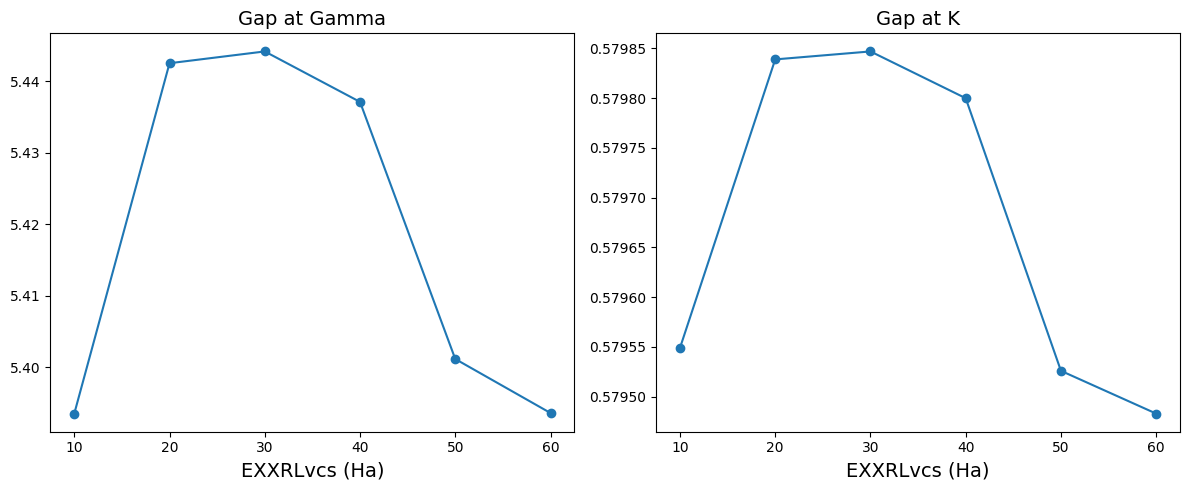

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 50 Ha

### HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [11]:
RandQpts = 5000000
RandGvec = 200 

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {18:1,30:1,42:1,60:1,72:1,81:1}
K_index = {30:91,42:169,60:331,72:469,81:588}

EXXRLvcs = 50. # Ha
EXXRLVcs_units = 'Ha'

In [25]:
kpoints = [30,42,60,72,81]

In [26]:
study = D.Dataset(num_tasks=10,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis/kpoints_%s-nbnds_30.save'%k
    run_dir = 'GW_analysis/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.4') 
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])

Initialize a Dataset with 10 parallel tasks
SAVE folder GW_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis/kpoints_60-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis/kpoints_72-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis/kpoints_81-nbnds_30/SAVE already present. No operations performed.


In [27]:
#study.runs[1]

In [ ]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of hf-G-kpoints_30
Skip the run of hf-G-kpoints_42
Skip the run of hf-G-kpoints_72
Skip the run of hf-G-kpoints_60
Skip the run of hf-G-kpoints_81
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F hf-K-kpoints_30.in -J "hf-K-kpoints_30,ndb_rim_cutoff" -C hf-K-kpoints_30
slurm submit:  run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F hf-K-kpoints_72.in -J "hf-K-kpoints_72,ndb_rim_cutoff" -C hf-K-kpoints_72cd GW_analysis/kpoints_30-nbnds_30 ; sbatch job_hf-K-kpoints_30.sh

computation hf-K-kpoints_30 is running...slurm submit: 
 cd GW_analysis/kpoints_72-nbnds_30 ; sbatch job_hf-K-kpoints_72.sh
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F hf-K-kpoints_8

In [35]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([3.924426, 3.869248, 3.86092, 3.860386, 3.860988],
 [1.058447, 0.906915, 0.858323, 0.8339890000000001, 0.828608])

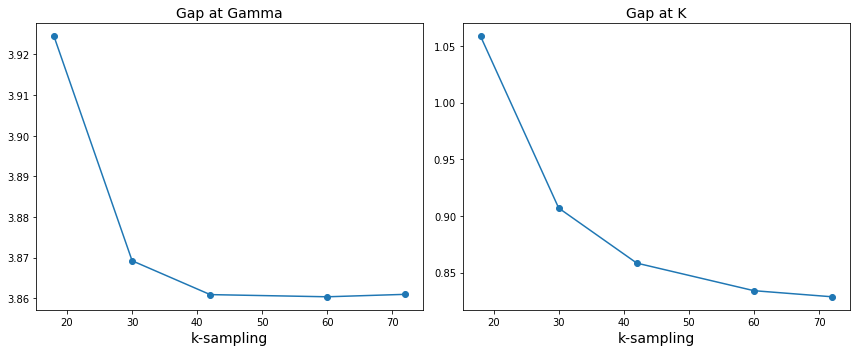

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

With the 60x60x1 sampling the HF gap both at $\Gamma$ and at $K$ is converged at
the level of 5 meV.